<a href="https://colab.research.google.com/github/hunterblum/MLFinal/blob/main/Group2_ML_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Real vs. Fake Job Classification
Modules

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline
from google.colab import files
import nltk
from nltk.corpus import stopwords
import seaborn as sns
from wordcloud import WordCloud
from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Perceptron
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn import model_selection, naive_bayes, svm
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier

In [2]:
#Download 'stopwords'
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Import original data set

In [5]:
uploaded = files.upload()

Saving fake_job_postings.csv to fake_job_postings.csv


Read in uploaded data

In [6]:
Job = pd.read_csv('fake_job_postings.csv')
Job.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


Data Read in For Local Jupyter Notebook

In [ ]:
Job = pd.read_csv('C:\\Users\\HunterBlum\\OneDrive\\School\\SanDiego\\Courses\\MLDL\\fake_job_postings.csv')
Job.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


## EDA
### Structure of Data
Shape

In [ ]:
Job.shape

(17880, 18)

NAs by feature

In [ ]:
Job.isnull().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

NAs by row

In [ ]:
NA_row = []
for i in range(len(Job.index)):
  na_temp = Job.iloc[i].isnull().sum()
  NA_row.append({'row': i+1, 'NAs': na_temp})

NA_row = pd.DataFrame(NA_row)
NA_row = NA_row.sort_values('NAs', ascending=False)
NA_row

,row,NAs
11077,11078,11
144,145,11
16627,16628,11
17756,17757,11
2315,2316,11
...,...,...
15825,15826,0
11435,11436,0
11441,11442,0
15789,15790,0


Data Types

In [ ]:
Job.dtypes

job_id                  int64
title                  object
location               object
department             object
salary_range           object
company_profile        object
description            object
requirements           object
benefits               object
telecommuting           int64
has_company_logo        int64
has_questions           int64
employment_type        object
required_experience    object
required_education     object
industry               object
function               object
fraudulent              int64
dtype: object

Unique Observations

In [ ]:
Job.nunique()

job_id                 17880
title                  11231
location                3105
department              1337
salary_range             874
company_profile         1709
description            14801
requirements           11968
benefits                6205
telecommuting              2
has_company_logo           2
has_questions              2
employment_type            5
required_experience        7
required_education        13
industry                 131
function                  37
fraudulent                 2
dtype: int64

Label Distribution

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Fraudulent Distribution (1 = Fraud)')

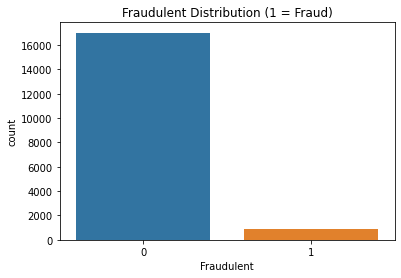

In [ ]:
labels = Job['fraudulent']


sns.countplot(labels)
plt.xlabel("Fraudulent")
plt.title("Fraudulent Distribution (1 = Fraud)")

By Count

In [ ]:
Label_count = Job.groupby(['fraudulent'])['fraudulent'].count()
print(Label_count)

fraudulent
0    17014
1      866
Name: fraudulent, dtype: int64


### EDA

NAs effect on fraud

Text(0.5, 0, 'Fraudulent (1 = Fraud)')

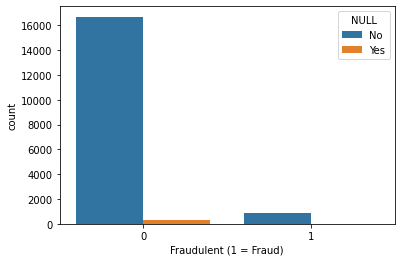

In [ ]:
Job_null = pd.DataFrame()
Job_null['NULL'] = np.where(Job['location'].isnull(), "Yes", "No")
Job_null['Fraudulent'] = Job['fraudulent']
sns.countplot(x="Fraudulent", hue="NULL", data=Job_null)
plt.xlabel("Fraudulent (1 = Fraud)")

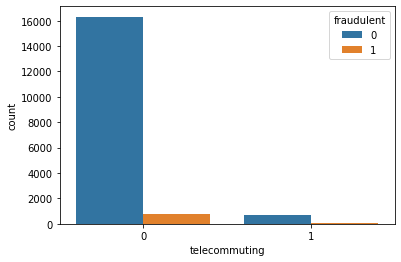

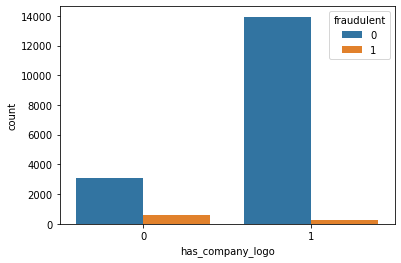

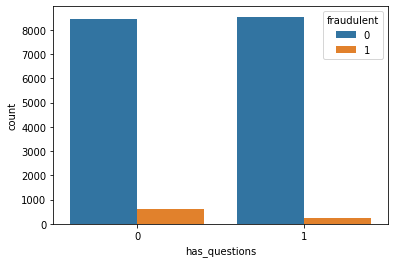

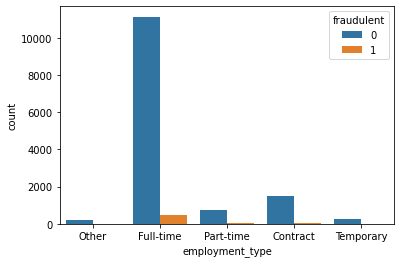

In [ ]:
# more EDA

# checking relationship between fraud and other categories with limited unique values

cat_lim = ['telecommuting','has_company_logo','has_questions', 'employment_type']
for i in cat_lim:
  sns.countplot(x=i, hue="fraudulent", data=Job)
  plt.show()

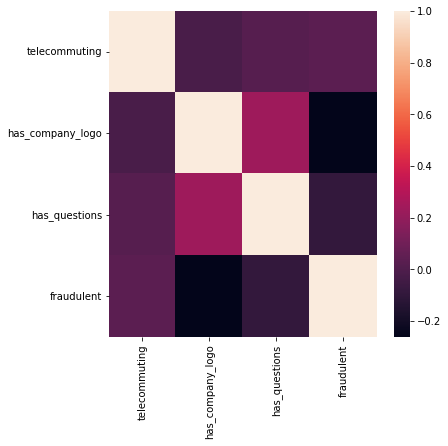

In [ ]:
plt.figure(figsize = (6,6))
cat_lim_tar = pd.concat([Job[cat_lim], Job['fraudulent']], axis = 1)
sns.heatmap(cat_lim_tar.corr());

Fill NAs with " " so our strings don't delete when combined

In [7]:
Job.fillna(" ", inplace = True)

## Creating Text Dataset


In [8]:
# Not keeping non-text variables in Job_corpus, we can add them back later
Job_corpus = pd.DataFrame()
Job_corpus['fraudulent'] = Job['fraudulent']
Job_corpus['corpus'] = Job['title'] + ' ' + Job['location'] + ' ' + Job['department'] + ' ' + Job['company_profile'] + ' ' + Job['description'] + ' ' + Job['requirements'] + ' ' + Job['benefits'] + ' ' + Job['employment_type'] + ' ' + Job['required_education'] + ' ' + Job['industry'] + ' ' + Job['function']

### Cleaning the corpus variable
Lowercase

In [9]:
Job_corpus['corpus'] = Job_corpus['corpus'].str.lower()

Remove unicode characters

In [10]:
corpus_uni = []
for ind in Job_corpus.index:
  x = Job_corpus['corpus'][ind]
  temp = x.encode('ascii', 'ignore').decode()
  corpus_uni.append(temp)

Job_corpus['corpus'] = corpus_uni


Remove Stop words

In [11]:
stop = stopwords.words("english")
corpus_stop = []
for ind in Job_corpus.index:
  x = Job_corpus['corpus'][ind]
  temp = ' '.join([word for word in x.split(' ') if word not in stop])
  corpus_stop.append(temp)

Job_corpus['corpus'] = corpus_stop

### EDA with word cloud


In [ ]:
# Split true and false fraud
Fraud = Job_corpus[(Job_corpus['fraudulent'] == 1)]
Real = Job_corpus[(Job_corpus['fraudulent'] == 0)]

# Create bag of words
Fraud_words = ''
for ind in Fraud.index:
  string = str(Fraud['corpus'][ind])
  token = string.split()
  Fraud_words += " ".join(token)+" "

Real_words = ''
for ind in Real.index:
  string = str(Real['corpus'][ind])
  token = string.split()
  Real_words += " ".join(token)+" "


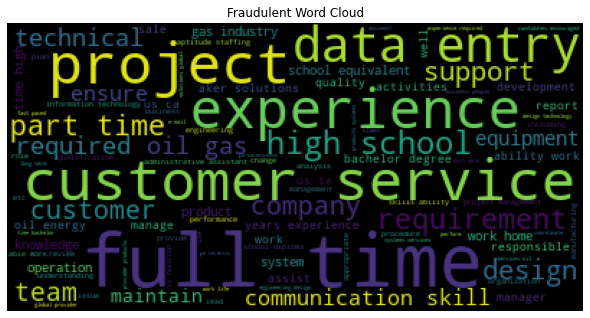

In [ ]:
cloud_fraud = WordCloud().generate(Fraud_words)
plt.figure(figsize= (8,8))
plt.imshow(cloud_fraud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.title("Fraudulent Word Cloud")
plt.show()

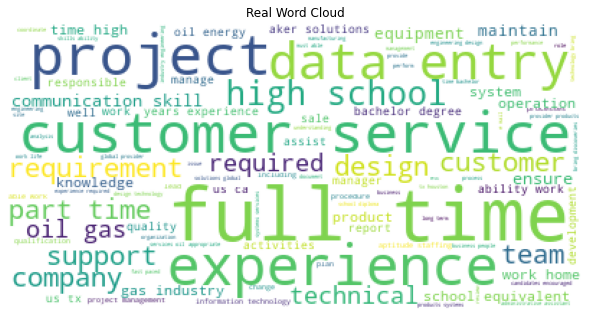

In [ ]:
color_real = WordCloud(background_color='white').generate(Fraud_words)
plt.figure(figsize= (8,8))
plt.imshow(color_real)
plt.axis("off")
plt.tight_layout(pad=0)
plt.title("Real Word Cloud")
plt.show()

Run Vectorizer

In [12]:
# Drop the fraud variaable
Job_corpus = Job_corpus.drop(columns = ['fraudulent'])
vectorizer = TfidfVectorizer()
spmat = vectorizer.fit_transform(Job_corpus['corpus'])
feat_names = vectorizer.get_feature_names()
Job_corpus = pd.DataFrame.sparse.from_spmatrix(spmat, columns=feat_names)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
Job_corpus

,00,000,0000,0001pt,0005,000a,000aed,000annual,000apply,000applying,...,zurich,zus,zusammen,zusammenarbeitest,zusammenbringt,zutrifft,zweig,zylun,zyluns,zynga
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.080592,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.045063,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,0.0,0.027459,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17876,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17877,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17878,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Undersample to balance classes
Create the dataset

In [13]:
X = Job.drop(columns = ['job_id', 'telecommuting', 'has_company_logo', 'has_questions', 'fraudulent'])
y = np.array(Job['fraudulent'])

undersample = RandomUnderSampler(random_state = 42)
Job_under, y_under = undersample.fit_resample(X,y)
Job_under['fraudulent'] = y_under

C:\ProgramData\Miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Fraudulent Distribution (1 = Fraud)')

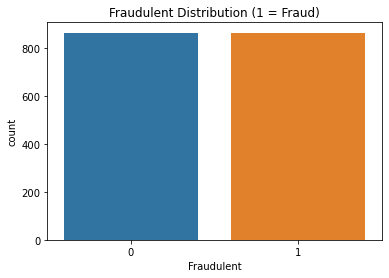

In [ ]:
sns.countplot(y_under)
plt.xlabel("Fraudulent")
plt.title("Fraudulent Distribution (1 = Fraud)")

Clean Data like before

In [14]:
# Not keeping non-text variables in Job_corpus, we can add them back later
Job_corpus_under = pd.DataFrame()
Job_corpus_under['fraudulent'] = Job_under['fraudulent']
Job_corpus_under['corpus'] = Job_under['title'] + ' ' + Job_under['location'] + ' ' + Job_under['department'] + ' ' + Job_under['company_profile'] + ' ' + Job_under['description'] + ' ' + Job_under['requirements'] + ' ' + Job_under['benefits'] + ' ' + Job_under['employment_type'] + ' ' + Job_under['required_education'] + ' ' + Job_under['industry'] + ' ' + Job_under['function']

Lowercase

In [15]:
Job_corpus_under['corpus'] = Job_corpus_under['corpus'].str.lower()

Remove unicode

In [16]:
corpus_uni = []
for ind in Job_corpus_under.index:
  x = Job_corpus_under['corpus'][ind]
  temp = x.encode('ascii', 'ignore').decode()
  corpus_uni.append(temp)

Job_corpus_under['corpus'] = corpus_uni


Remove Stopwords

In [17]:
stop = stopwords.words("english")
corpus_stop = []
for ind in Job_corpus_under.index:
  x = Job_corpus_under['corpus'][ind]
  temp = ' '.join([word for word in x.split(' ') if word not in stop])
  corpus_stop.append(temp)

Job_corpus_under['corpus'] = corpus_stop

### EDA with Wordcloud on Undersampled Data

In [ ]:
# Split true and false fraud
Fraud = Job_corpus_under[(Job_corpus_under['fraudulent'] == 1)]
Real = Job_corpus_under[(Job_corpus_under['fraudulent'] == 0)]

# Create bag of words
Fraud_words = ''
for ind in Fraud.index:
  string = str(Fraud['corpus'][ind])
  token = string.split()
  Fraud_words += " ".join(token)+" "

Real_words = ''
for ind in Real.index:
  string = str(Real['corpus'][ind])
  token = string.split()
  Real_words += " ".join(token)+" "


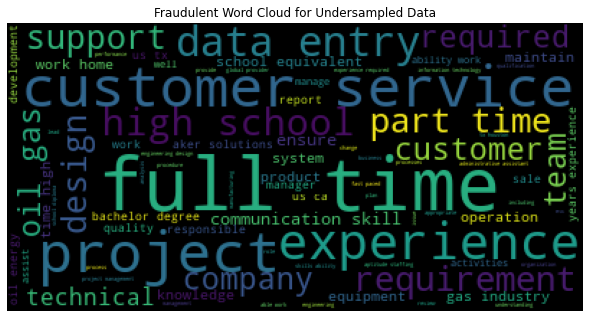

In [ ]:
cloud_fraud = WordCloud().generate(Fraud_words)
plt.figure(figsize= (8,8))
plt.imshow(cloud_fraud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.title("Fraudulent Word Cloud for Undersampled Data")
plt.show()

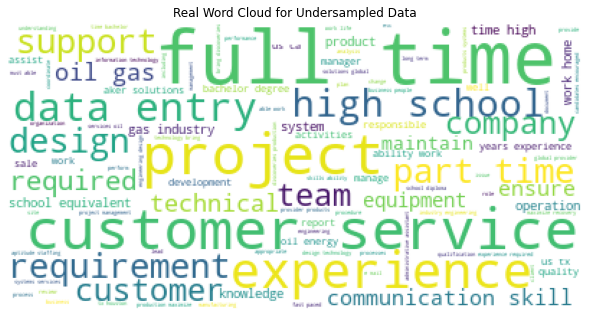

In [ ]:
color_real = WordCloud(background_color='white').generate(Fraud_words)
plt.figure(figsize= (8,8))
plt.imshow(color_real)
plt.axis("off")
plt.tight_layout(pad=0)
plt.title("Real Word Cloud for Undersampled Data")
plt.show()

Run Vectorizer

In [18]:
# Drop the fraud variable
Job_corpus_under = Job_corpus_under.drop(columns = ['fraudulent'])
vectorizer = TfidfVectorizer()
spmat = vectorizer.fit_transform(Job_corpus_under['corpus'])
feat_names = vectorizer.get_feature_names()
Job_corpus_under = pd.DataFrame.sparse.from_spmatrix(spmat, columns=feat_names)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## Separated section dataset

In [24]:
text = Job[['title','location', 'company_profile', 'description', 'requirements', 'benefits']]
text.head()

,title,location,company_profile,description,requirements,benefits
0,Marketing Intern,"US, NY, New York","We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,
1,Customer Service - Cloud Video Production,"NZ, , Auckland","90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,
3,Account Executive - Washington DC,"US, DC, Washington",Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...
4,Bill Review Manager,"US, FL, Fort Worth",SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered


Undersample

In [25]:
# let's look at each text feature
# text features are:
# 'title', 'location', 'company_profile', 'description', 'requirements', 'benefits' and (perhaps) 'industry'
# going to fill text nulls with " " 

text = Job_under[['title','location', 'department', 'company_profile', 'description', 'requirements', 'benefits']]
text.fillna(" ", inplace = True)
text.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


,title,location,department,company_profile,description,requirements,benefits
0,SEM Coordinator,"GR, I, Athens",,#URL_c379aa631173ed5b7c345ab3f500a9a053e509138...,The right candidate will be responsible for co...,- Previous experience of minimum 3 years...,- Attractive Remuneration Package.- ...
1,Senior Data Scientist,"GB, LND, London",Engineering,"As a growing and successful startup, Conversoc...",Conversocial builds software that helps compan...,Good working knowledge of Python or similar la...,Salary of £40-55k plus stock options£2k annual...
2,Junior Web Marketing Specialist,"GR, I, Ilion",Web Marketing και Social,Η Atnet Communications A.E. είναι μια αμιγώς ε...,Η Atnet Communications αναζητά Junior Web Mark...,Απαιτούμενα προσόντα:Hands-on εμπειρία στην δι...,H θέση αφορά μόνιμη απασχόληση στην περιοχή το...
3,New Product Development Project Leader - Full ...,"US, GA, Atlanta",,We Provide Full Time Permanent Positions for m...,Coordination and project management of New Pro...,"Location - Atlanta, GA, USAJob Type – Permanen...",
4,Data Intern - Retail & Apparel Analysis,"GB, LND, London",Fashion:Internships,"We build software for fashion retailers, to he...",About EDITDEDITD’s software is the market lead...,,


Vectorizing each text section

In [26]:
# vectorizing title

vectorizer = TfidfVectorizer()
spmat_title = vectorizer.fit_transform(text['title'])
feat_names = vectorizer.get_feature_names_out()
title_corpus = pd.DataFrame.sparse.from_spmatrix(spmat_title, columns=feat_names)

In [27]:
# vectorizing location

vectorizer = TfidfVectorizer()
spmat_location = vectorizer.fit_transform(text['location'])
feat_names = vectorizer.get_feature_names_out()
location_corpus = pd.DataFrame.sparse.from_spmatrix(spmat_location, columns=feat_names)

In [28]:
# vectorizing company_profile

vectorizer = TfidfVectorizer()
spmat_company = vectorizer.fit_transform(text['company_profile'])
feat_names = vectorizer.get_feature_names_out()
company_corpus = pd.DataFrame.sparse.from_spmatrix(spmat_company, columns=feat_names)

In [29]:
# vectorizing description

vectorizer = TfidfVectorizer()
spmat_description = vectorizer.fit_transform(text['description'])
feat_names = vectorizer.get_feature_names_out()
description_corpus = pd.DataFrame.sparse.from_spmatrix(spmat_description, columns=feat_names)


# vectorizing requirements

vectorizer = TfidfVectorizer()
spmat_requirements = vectorizer.fit_transform(text['requirements'])
feat_names = vectorizer.get_feature_names_out()
requirements_corpus = pd.DataFrame.sparse.from_spmatrix(spmat_requirements, columns=feat_names)

# vectorizing benefits

vectorizer = TfidfVectorizer()
spmat_benefits = vectorizer.fit_transform(text['benefits'])
feat_names = vectorizer.get_feature_names_out()
benefits_corpus = pd.DataFrame.sparse.from_spmatrix(spmat_benefits, columns=feat_names)

In [30]:
text_fts = [title_corpus, location_corpus, company_corpus, description_corpus, requirements_corpus, benefits_corpus]


## Creating Categorical Data set

In [31]:
# creating cat_df
# need to import onehotencoder

# cat variables are 

cats = Job_under[['employment_type', 'required_experience', 'required_education', 'function']]

# converting using one hot encoder

ohe = OneHotEncoder(drop = 'first', 
                    sparse = False).fit(cats) # dropping first column of each feature to not reduce redudancy
cat_data = ohe.transform(cats)
cat_df = pd.DataFrame(cat_data, columns = ohe.get_feature_names_out(['employment_type',  'required_experience', 'required_education', 'function'])) 
cat_df.head()

,employment_type_Contract,employment_type_Full-time,employment_type_Other,employment_type_Part-time,employment_type_Temporary,required_experience_Associate,required_experience_Director,required_experience_Entry level,required_experience_Executive,required_experience_Internship,...,function_Project Management,function_Public Relations,function_Purchasing,function_Quality Assurance,function_Research,function_Sales,function_Strategy/Planning,function_Supply Chain,function_Training,function_Writing/Editing
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Correlation Matrix

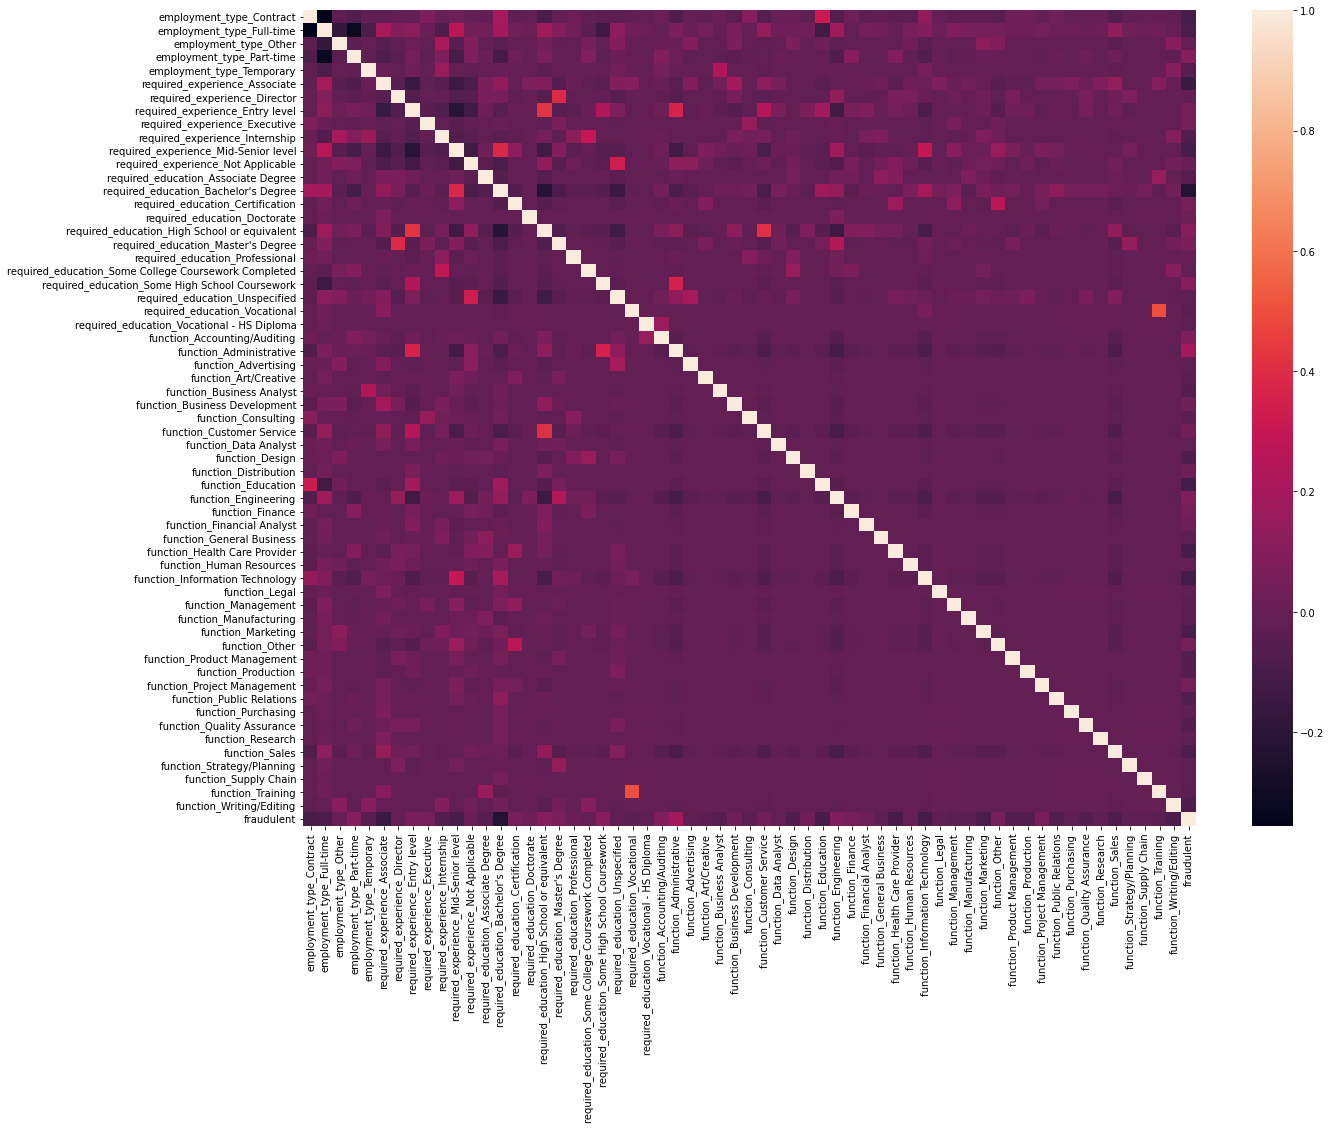

In [32]:
# let's see some correlations between categorical data and the fraudulency

cat_tar = pd.concat([cat_df, Job_under['fraudulent']], axis =1)

plt.figure(figsize = (20,15))
sns.heatmap(cat_tar.corr());

# Modeling

## Perceptrons


### Perceptron with undersampled text section data

In [ ]:
text_fts = [title_corpus, location_corpus, company_corpus, description_corpus, requirements_corpus, benefits_corpus]
labels = y_under
text_ft_accuracy = []

for i  in text_fts:
  X_train, X_test, y_train, y_test = train_test_split(i, labels, train_size = 0.80, random_state=42)
  model = Perceptron(max_iter=3).fit(X_train, y_train)
  y_pred_train = model.predict(X_train)
  y_pred_test = model.predict(X_test)
  train_acc = accuracy_score(y_train, y_pred_train)
  test_acc = accuracy_score(y_test, y_pred_test)
  text_ft_accuracy.append({'training accuracy': train_acc, 'testing accuracy': test_acc})

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\line

In [ ]:
text_ft_accuracy

[{'training accuracy': 0.9032490974729241,
  'testing accuracy': 0.8213256484149856},
 {'training accuracy': 0.8043321299638989,
  'testing accuracy': 0.6657060518731989},
 {'training accuracy': 0.6534296028880866,
  'testing accuracy': 0.6628242074927954},
 {'training accuracy': 0.9884476534296028,
  'testing accuracy': 0.8414985590778098},
 {'training accuracy': 0.9155234657039711,
  'testing accuracy': 0.7665706051873199},
 {'training accuracy': 0.779783393501805,
  'testing accuracy': 0.7002881844380403}]

In [ ]:
# running this again, but with top 10, 25, and 50 features
from sklearn.feature_selection import SelectKBest, chi2

k_vals = [10, 25, 50]
text_topft_accuracy = []
for i  in text_fts:
  X_train, X_test, y_train, y_test = train_test_split(i, labels, train_size = 0.80, random_state=42)
  for k in k_vals:
    pipe = make_pipeline(SelectKBest(chi2, k = k), Perceptron(class_weight = 'balanced'))
    pipe.fit(X_train, y_train)
    y_pred_train = pipe.predict(X_train)
    y_pred_test = pipe.predict(X_test)
    cols = pipe[0].get_support(indices = True)
    new_X_features = X_train.iloc[:, cols]
    print('X_new has', k ,'best features: %s' % list(new_X_features.columns.values.tolist()))

    train_acc = accuracy_score(y_train, y_pred_train)
    test_acc = accuracy_score(y_test, y_pred_test)

    text_topft_accuracy.append({'Top k features': k, 'Training Accuracy': train_acc, 'Test Accuracy': test_acc})


X_new has 10 best features: ['abroad', 'administrative', 'assistant', 'clerk', 'data', 'developer', 'english', 'entry', 'payroll', 'teacher']
X_new has 25 best features: ['abroad', 'admin', 'administrative', 'assistant', 'based', 'clerical', 'clerk', 'conversational', 'cruise', 'daily', 'data', 'developer', 'earn', 'english', 'entry', 'home', 'payroll', 'position', 'positions', 'software', 'staff', 'teacher', 'technician', 'urgent', 'web']
X_new has 50 best features: ['000', '100', '200', 'abroad', 'admin', 'administrative', 'analyst', 'assistant', 'based', 'call', 'cash', 'clerical', 'clerk', 'clerks', 'conversational', 'cruise', 'daily', 'data', 'designer', 'developer', 'devops', 'digital', 'earn', 'english', 'entry', 'graduates', 'home', 'ios', 'jobs', 'managers', 'mechanical', 'net', 'network', 'office', 'payroll', 'position', 'positions', 'receptionist', 'rep', 'rn', 'software', 'staff', 'teacher', 'technician', 'typist', 'urgent', 'wanted', 'web', 'workers', 'yr']
X_new has 10 be

Order of features: [title_corpus, location_corpus, company_corpus, description_corpus, requirements_corpus, benefits_corpus]

In [ ]:
pd.DataFrame(text_topft_accuracy)

,Top k features,Training Accuracy,Test Accuracy
0,10,0.589170,0.538905
1,25,0.602888,0.561960
2,50,0.723466,0.674352
3,10,0.575451,0.587896
4,25,0.592780,0.619597
5,50,0.649097,0.668588
6,10,0.672202,0.639769
7,25,0.826715,0.838617
8,50,0.831769,0.824207
9,10,0.618051,0.576369


Each text feature seemed to have very accurate results with the data, but only ones like location and benefits had accurate results with limited/most important features

**longer way below, not looped**
first, title_corpus

X_train, X_test, y_train, y_test = train_test_split(title_corpus, labels, test_size = 0.80, random_state=42)
title_model = Perceptron(max_iter=1).fit(X_train, y_train)

title_pred = title_model.predict(X_test)

accuracy = accuracy_score(title_pred, y_test)

text_ft_accuracy = []
text_ft_accuracy.append({'Title': accuracy})

### Perceptron with Categorical Data

In [ ]:
# using these categorical variables to predict 
labels = y_under
X_train, X_test, y_train, y_test = train_test_split(cat_df, labels, train_size = 0.80, random_state=42)

from sklearn.impute import SimpleImputer

mode_imputer = SimpleImputer(strategy = 'most_frequent') # imputing categorical features with mode
balanced_model = make_pipeline(mode_imputer, Perceptron(class_weight='balanced', random_state = 42))

balanced_model.fit(X_train, y_train)


# make predictions on training set
y_pred_b = balanced_model.predict(X_train)

# make predictions on test set
y_pred_test_b = balanced_model.predict(X_test)

# print the results 
print("Balanced Accuracy:"); print("="*len("Accuracy:"))
print(f"Balanced TRAIN: {accuracy_score(y_train, y_pred_b)}")
print(f"Balanced TEST: {accuracy_score(y_test, y_pred_test_b)}")

Balanced Accuracy:
Balanced TRAIN: 0.6483754512635379
Balanced TEST: 0.6311239193083573


### Perceptron with Undersampled Corpus Data
After running perceptrons on both categorical and text data, let's try to run it on "all" the text data (corpus) and then a combination of seemingly relevant text features and categorical features. First, corpus

Model Creation

In [33]:
# running Perceptron on all data
y = y_under
labenc = LabelEncoder()
y = labenc.fit_transform(y)

X = Job_corpus_under.drop(columns = ['fraudulent'])

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.80, random_state=42)

penalty = ['l1', 'l2', 'elasticnet']
alpha =  [int(x) for x in np.linspace(start = .0001, stop=1, num = 10)]
iterations = [10, 50, 100, 200, 500, 1000]

tr_grid = {'penalty': penalty,
           'alpha': alpha,
           'max_iter': iterations}
perc = Perceptron()

perc_tuned = GridSearchCV(estimator = perc, param_grid = tr_grid, cv = 5, n_jobs = 6, verbose = 10)

perc_tuned.fit(X_train, y_train)
perc_tuned.score(X_train, y_train)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


ERROR:concurrent.futures:exception calling callback for <Future at 0x7f9bb0b24150 state=finished raised BrokenProcessPool>
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py", line 407, in _process_worker
    call_item = call_queue.get(block=True, timeout=timeout)
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 99, in get
    if not self._rlock.acquire(block, timeout):
KeyboardInterrupt
"""

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "/usr/local/lib/python3.7/dist-packages/joblib/parallel.py", line 359, in __call__
    self.parallel.dispatch_next()
  File "/usr/local/lib/python3.7/dist-packages/joblib/parallel.py", line 794, in dispatch_next
    

KeyboardInterrupt: ignored

In [ ]:
perc_tuned.best_params_

{'alpha': 0, 'max_iter': 10, 'penalty': 'l1'}

In [34]:
# creating base model

perc = Perceptron(alpha = 0, max_iter = 10, penalty = 'l1', random_state = 42)

perc.fit(X_train, y_train)
y_pred = perc.predict(X_test)

In [35]:
# getting accuracy scores

perc_all_acc = accuracy_score(y_test, y_pred)
perc_all_f1 = f1_score(y_test, y_pred)
print("Accuracy: ", perc_all_acc,
      "\nF1 Score:", perc_all_f1,
      )

Accuracy:  0.9193083573487032 
F1 Score: 0.9176470588235295


In [ ]:
# creating confusion matrix

text_labels = ["Real", "Fraud"]
perc_cm = confusion_matrix(y_test, y_pred)
pd.DataFrame(perc_cm, index = text_labels, columns = text_labels)

,Real,Fraud
Real,163,19
Fraud,9,156


In [36]:
y = y_under
labenc = LabelEncoder()
y = labenc.fit_transform(y)

X = Job_corpus_under.drop(columns = ['fraudulent'])

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.80, random_state=42)

perc_all_corpus = []
for i in range(1,15):
  model = Perceptron(max_iter = i).fit(X_train, y_train)
  y_pred_train = model.predict(X_train)
  y_pred_test = model.predict(X_test)
  train_acc = accuracy_score(y_train, y_pred_train)
  train_f1 = f1_score(y_train, y_pred_train)
  test_acc = accuracy_score(y_test, y_pred_test)
  test_f1 = f1_score(y_test, y_pred_test)
  perc_all_corpus.append({"Iterations": i, "Training Accuracy": train_acc, "Training F1": train_f1, "Testing Accuracy": test_acc, "Testing F1": test_f1})

perc_all_corpus = pd.DataFrame(perc_all_corpus)
perc_all_corpus

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_mo

KeyboardInterrupt: ignored

Save Top Results

In [ ]:
perc_under_corp_acc = perc_all_corpus['Testing Accuracy'].max()
perc_under_corp_f1 = perc_all_corpus['Testing F1'].max()

print("Accuracy:", perc_under_corp_acc, "\nF1 Score:", perc_under_corp_f1)

Accuracy: 0.9365994236311239 
F1 Score: 0.9312500000000001


Tuning Results Plot

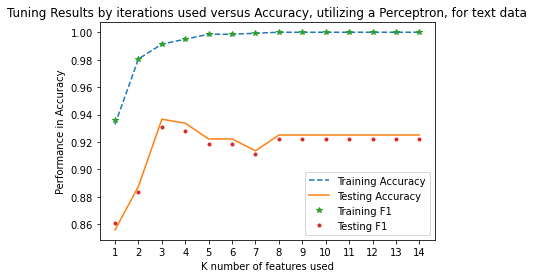

In [ ]:
# here is for both training and testing

plt.plot(perc_all_corpus['Iterations'], perc_all_corpus['Training Accuracy'], '--', label='Training Accuracy')
plt.plot(perc_all_corpus['Iterations'], perc_all_corpus['Testing Accuracy'], label='Testing Accuracy')
plt.plot(perc_all_corpus['Iterations'], perc_all_corpus['Training F1'], '*', label='Training F1')
plt.plot(perc_all_corpus['Iterations'], perc_all_corpus['Testing F1'], '.', label='Testing F1')

plt.xticks(perc_all_corpus['Iterations'])
plt.legend(loc = 'lower right')
plt.xlabel('K number of features used')
plt.ylabel('Performance in Accuracy')
plt.title("Tuning Results by iterations used versus Accuracy, utilizing a Perceptron, for text data");


### Perceptron with Undersampled Corpus + Categorical Data




In [ ]:
# combining categorical features and text features

# first, choosing text features based on training error
Job_corpus_cat = pd.DataFrame()
Job_corpus_cat['fraudulent'] = Job_under['fraudulent']
Job_corpus_cat['corpus'] = text['title'] + ' ' + text['location'] + ' ' + text['description']

# making all text lower case 
Job_corpus_cat['corpus'] = Job_corpus_cat['corpus'].str.lower()

# vectorizing Job_corpus_under
vectorizer = TfidfVectorizer()
spmat_location = vectorizer.fit_transform(Job_corpus_cat['corpus'])
feat_names = vectorizer.get_feature_names_out()
job_corpus_less = pd.DataFrame.sparse.from_spmatrix(spmat_location, columns=feat_names)

# combining job_corpus_less with cat_df
job_corpus_cat = pd.concat([job_corpus_less, cat_df], axis = 1)

In [ ]:
# now running this on the combined text and categorical data

y = y_under
labenc = LabelEncoder()
y = labenc.fit_transform(y)

X = job_corpus_cat.drop(columns = ['fraudulent'])

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.80, random_state=42)

perc_cat_corpus = []
for i in range(1,15):
  model = Perceptron(max_iter = i).fit(X_train, y_train)
  y_pred_train = model.predict(X_train)
  y_pred_test = model.predict(X_test)
  train_acc = accuracy_score(y_train, y_pred_train)
  train_f1 = f1_score(y_train, y_pred_train)
  test_acc = accuracy_score(y_test, y_pred_test)
  test_f1 = f1_score(y_test, y_pred_test)
  perc_cat_corpus.append({"Iterations": i, "Training Accuracy": train_acc, "Training F1": train_f1, "Testing Accuracy": test_acc, "Testing F1": test_f1})

perc_cat_corpus = pd.DataFrame(perc_cat_corpus)
perc_cat_corpus

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py:758: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py:758: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py:758: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py:758: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
 

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py:758: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py:758: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py:758: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py:758: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
 

,Iterations,Training Accuracy,Training F1,Testing Accuracy,Testing F1
0,1,0.872924,0.880109,0.763689,0.777174
1,2,0.859206,0.876972,0.769452,0.797980
2,3,0.838267,0.861214,0.731988,0.768080
3,4,0.950181,0.948927,0.829971,0.805281
4,5,0.925632,0.931196,0.798271,0.809783
5,6,0.967509,0.968465,0.786744,0.789773
6,7,0.948014,0.946824,0.835735,0.823529
7,8,0.983394,0.983489,0.841499,0.832827
8,9,0.989170,0.989263,0.838617,0.827160
9,10,0.978339,0.979050,0.789625,0.800000


Get Best Acc and F1

In [ ]:
perc_cat_corp_acc = perc_cat_corpus['Testing Accuracy'].max()
perc_cat_corp_f1 = perc_cat_corpus['Testing F1'].max()

print("Accuracy:", perc_cat_corp_acc, "\nF1 Score:", perc_cat_corp_f1)

Accuracy: 0.8530259365994236 
F1 Score: 0.8360128617363344


## AdaBoost

### AdaBoost for Undersampled Corpus

Build Model 

In [ ]:
np.linspace(start = .00001, stop=2, num = 10)

array([1.00000000e-05, 2.22231111e-01, 4.44452222e-01, 6.66673333e-01,
       8.88894444e-01, 1.11111556e+00, 1.33333667e+00, 1.55555778e+00,
       1.77777889e+00, 2.00000000e+00])

In [ ]:
# first, to run AdaBoost on the all corpus text data
y = y_under
labenc = LabelEncoder()
y = labenc.fit_transform(y)

X = Job_corpus_under.drop(columns = ['fraudulent'])

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.80, random_state=42)

n_estimators = [10,25,50,100,150,200]
learning_rate =  [int(x) for x in np.linspace(start = .0001, stop=2, num = 10)]

tr_grid = {'n_estimators': n_estimators,
           'learning_rate': learning_rate}
ada = AdaBoostClassifier()

ada_tuned = GridSearchCV(estimator = ada, param_grid = tr_grid, cv = 5, n_jobs = 6, verbose = 10)

ada_tuned.fit(X_train, y_train)


Fitting 5 folds for each of 60 candidates, totalling 300 fits


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
150 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
150 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py", line 506, in fit
    return super().fit(X, y, sample_weight)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py", line 123, in fit
    check_scalar(
  File "C:\ProgramData\Mini

GridSearchCV(cv=5, estimator=AdaBoostClassifier(), n_jobs=6,
             param_grid={'learning_rate': [0, 0, 0, 0, 0, 1, 1, 1, 1, 2],
                         'n_estimators': [10, 25, 50, 100, 150, 200]},
             verbose=10)

We used the default model, which is a decision stump, within AdaBoost

In [ ]:
ada_tuned.score(X_train, y_train)

1.0

In [ ]:
ada_tuned.best_params_

{'learning_rate': 1, 'n_estimators': 200}

In [ ]:
# creating base model

ada_final = AdaBoostClassifier(learning_rate = 1, n_estimators = 200, random_state = 42)

ada_final.fit(X_train, y_train)
y_pred = ada_final.predict(X_test)

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py:758: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py:758: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


In [ ]:
# getting accuracy scores

ada_all_acc = accuracy_score(y_test, y_pred)
ada_all_f1 = f1_score(y_test, y_pred)
print("Accuracy: ", ada_all_acc,
      "\nF1 Score:", ada_all_f1,
      )

Accuracy:  0.8357348703170029 
F1 Score: 0.830860534124629


In [ ]:
text_labels = ["Real", "Fraud"]
ada_cm = confusion_matrix(y_test, y_pred)
pd.DataFrame(ada_cm, index = text_labels, columns = text_labels)

,Real,Fraud
Real,150,32
Fraud,25,140


In [ ]:
# looping over AdaBoost on the all corpus text data to plot error 
# when adjusting learning rate
learning_rate =  [.001, .01, .1, .5, 1, 2, 5]
ada_all_corpus = []
for i in learning_rate:
  model = AdaBoostClassifier(n_estimators = 200, learning_rate = i).fit(X_train, y_train)
  y_pred_train = model.predict(X_train)
  y_pred_test = model.predict(X_test)
  train_acc = accuracy_score(y_train, y_pred_train)
  train_f1 = f1_score(y_train, y_pred_train)
  test_acc = accuracy_score(y_test, y_pred_test)
  test_f1 = f1_score(y_test, y_pred_test)
  ada_all_corpus.append({"Learning Rate": i, "Training Accuracy": train_acc, "Training F1": train_f1, "Testing Accuracy": test_acc, "Testing F1": test_f1})

pd.DataFrame(ada_all_corpus)

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py:758: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py:758: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py:758: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py:758: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py:758: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\ProgramData\Miniconda3

,Learning Rate,Training Accuracy,Training F1,Testing Accuracy,Testing F1
0,0.001,0.645487,0.532826,0.628242,0.513208
1,0.010,0.768231,0.772179,0.749280,0.735562
2,0.100,0.914079,0.913075,0.838617,0.828221
3,0.500,0.994224,0.994294,0.855908,0.851190
4,1.000,1.000000,1.000000,0.835735,0.830861
5,2.000,0.620217,0.726327,0.530259,0.650964
6,5.000,0.494585,0.002849,0.524496,0.000000


In [ ]:
ada_all_corpus = pd.DataFrame(ada_all_corpus)
ada_all_corpus_acc = ada_all_corpus['Testing Accuracy'].max()
ada_all_corpus_f1 = ada_all_corpus['Testing F1'].max()

print("Accuracy:", ada_all_corpus_acc, "\nF1 Score:", ada_all_corpus_f1)

Accuracy: 0.8559077809798271 
F1 Score: 0.8511904761904763


Tuning Plot

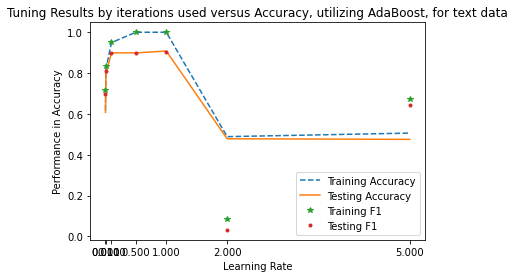

In [ ]:
# here is for both training and testing

ada_all_corpus = pd.DataFrame(ada_all_corpus)
plt.plot(ada_all_corpus['Learning Rate'], ada_all_corpus['Training Accuracy'], '--', label='Training Accuracy')
plt.plot(ada_all_corpus['Learning Rate'], ada_all_corpus['Testing Accuracy'], label='Testing Accuracy')
plt.plot(ada_all_corpus['Learning Rate'], ada_all_corpus['Training F1'], '*', label='Training F1')
plt.plot(ada_all_corpus['Learning Rate'], ada_all_corpus['Testing F1'], '.', label='Testing F1')

plt.xticks(ada_all_corpus['Learning Rate'])
plt.legend(loc = 'lower right')
plt.xlabel('Learning Rate')
plt.ylabel('Performance in Accuracy')
plt.title("Tuning Results by iterations used versus Accuracy, utilizing AdaBoost, for text data");

### AdaBoost with undersampled corpus and categorical data

Build Model

In [ ]:
# first, to run AdaBoost on the categorical and text data
y = y_under
labenc = LabelEncoder()
y = labenc.fit_transform(y)

X = job_corpus_cat.drop(columns = ['fraudulent'])

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.80, random_state=42)

n_estimators = [10,25,50,100,150,200]

ada_cat_corpus = []
for i in n_estimators:
  model = AdaBoostClassifier(n_estimators = i).fit(X_train, y_train)
  y_pred_train = model.predict(X_train)
  y_pred_test = model.predict(X_test)
  train_acc = accuracy_score(y_train, y_pred_train)
  train_f1 = f1_score(y_train, y_pred_train)
  test_acc = accuracy_score(y_test, y_pred_test)
  test_f1 = f1_score(y_test, y_pred_test)
  ada_cat_corpus.append({"Number of estimators": i, "Training Accuracy": train_acc, "Training F1": train_f1, "Testing Accuracy": test_acc, "Testing F1": test_f1})

pd.DataFrame(ada_cat_corpus)


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py:758: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py:758: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py:758: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py:758: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py:758: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\ProgramData\Miniconda3

,Number of estimators,Training Accuracy,Training F1,Testing Accuracy,Testing F1
0,10,0.774007,0.795023,0.720461,0.737127
1,25,0.829603,0.822823,0.812680,0.801223
2,50,0.907581,0.907781,0.873199,0.867470
3,100,0.972563,0.972740,0.844380,0.840237
4,150,0.994224,0.994286,0.829971,0.823881
5,200,1.000000,1.000000,0.835735,0.830861


In [ ]:
ada_cat_corpus = pd.DataFrame(ada_cat_corpus)
ada_cat_corpus_acc = ada_cat_corpus['Testing Accuracy'].max()
ada_cat_corpus_f1 = ada_cat_corpus['Testing F1'].max()

print("Accuracy:", ada_cat_corpus_acc, "\nF1 Score:", ada_cat_corpus_f1)

Accuracy: 0.8731988472622478 
F1 Score: 0.8674698795180722


## KNN

### KNN with Undersampled Corpus

KNN Function

In [ ]:
#This function is supposed to create and test a KNN model

def k_neighbors(xtrain, ytrain, xtest, ytest, kvalues, metric):
  knn_accuracy = []
  clfs = []
  for i in kvalues:
    clf = KNeighborsClassifier(metric=metric, n_neighbors=i).fit(xtrain, ytrain)
    clf_train_pred = clf.predict(xtrain)
    clf_test_pred = clf.predict(xtest)
    clfs.append(clf)
    knn_accuracy.append({'k values': i,
    'Training Accuracy':accuracy_score(clf_train_pred,ytrain),
    'Training F1': f1_score(clf_train_pred, y_train),
    'Test Accuracy': accuracy_score(clf_test_pred,ytest),
    'Test F1': f1_score(clf_test_pred,ytest)})
  return pd.DataFrame(knn_accuracy), clfs

KNN Modeling and Results

In [ ]:
# running all corpus data through KNN Function / model

y = y_under
labenc = LabelEncoder()
y = labenc.fit_transform(y)

X = Job_corpus_under.drop(columns = ['fraudulent'])

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.80, random_state=42)

knn_all_scores, knn_all_clfs = k_neighbors(X_train, y_train, X_test, y_test, range(1, 30, 2), 'euclidean')

knn_all_scores

,k values,Training Accuracy,Training F1,Test Accuracy,Test F1
0,1,1.000000,1.000000,0.910663,0.910663
1,3,0.939350,0.941667,0.890490,0.890173
2,5,0.914079,0.918100,0.873199,0.873563
3,7,0.905415,0.910212,0.867435,0.869318
4,9,0.891697,0.898236,0.861671,0.864407
5,11,0.877978,0.885888,0.829971,0.837466
6,13,0.870036,0.879195,0.835735,0.841226
7,15,0.867148,0.876344,0.832853,0.837989
8,17,0.864260,0.873144,0.832853,0.837079
9,19,0.858484,0.868102,0.818444,0.823529


In [ ]:
knn_all_acc = knn_all_scores['Test Accuracy'].max()
knn_all_f1 = knn_all_scores['Test F1'].max()

print("Accuracy:", knn_all_acc, "\nF1 Score:", knn_all_f1)

Accuracy: 0.9106628242074928 
F1 Score: 0.9106628242074928


Text(0.5, 1.0, 'Tuning Results by K number of neighbors versus Accuracy, \n measured by Euclidean distance metric')

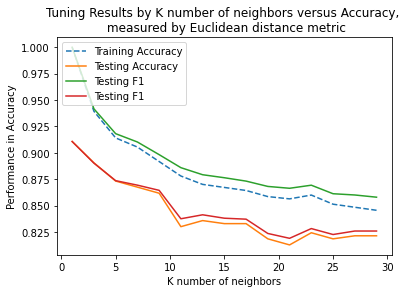

In [ ]:
# Plotting of accuracies training and testing of K-nn with Euclidean metric

plt.plot(range(1,30,2),knn_all_scores['Training Accuracy'],'--', label='Training Accuracy')
plt.plot(range(1,30,2),knn_all_scores['Test Accuracy'], label='Testing Accuracy')
plt.plot(range(1,30,2),knn_all_scores['Training F1'], label='Testing F1')
plt.plot(range(1,30,2),knn_all_scores['Test F1'], label='Testing F1')


plt.legend(loc='upper left')
plt.xlabel('K number of neighbors')
plt.ylabel('Performance in Accuracy')
plt.title("Tuning Results by K number of neighbors versus Accuracy, \n measured by Euclidean distance metric")

## Random Forest

### Random Forest with corpus data
Split data set

In [ ]:
y = Job['fraudulent']
labenc = LabelEncoder()
y = labenc.fit_transform(y)

X = Job_corpus.drop(columns = ['fraudulent'])

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.80, random_state=42)

Create Tuning Grid - Tuned locally to create more jobs. Best model found, 
{'n_estimators': 1800,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 90,
 'bootstrap': False}



In [ ]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 3000, num = 15)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 10, stop=210, num = 21)]
max_depth.append(None)
min_samples_split = [2,5,10,20]
min_samples_leaf = [1,2,4,8]
bootstrap = [True, False]

tr_grid = {'n_estimators': n_estimators,
           'max_features': max_features,
           'max_depth': max_depth,
           'min_samples_split': min_samples_split,
           'min_samples_leaf': min_samples_leaf,
           'bootstrap': bootstrap}
print(tr_grid)

forest = RandomForestClassifier()

forest_tuned = RandomizedSearchCV(estimator = forest, param_distributions=tr_grid,
                                  n_iter = 50, cv = 5, random_state = 42, n_jobs = 6, verbose = 10)
forest_tuned.fit(X_train, y_train)
forest_tuned.best_params_

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400, 2600, 2800, 3000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, None], 'min_samples_split': [2, 5, 10, 20], 'min_samples_leaf': [1, 2, 4, 8], 'bootstrap': [True, False]}
Fitting 5 folds for each of 50 candidates, totalling 250 fits


Create base model

In [ ]:
forest = RandomForestClassifier(n_estimators = 1800, min_samples_split = 5, min_samples_leaf = 1,
                               max_features = 'auto', max_depth = 90, bootstrap = False, verbose = 10)
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 1800


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


building tree 2 of 1800


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s


building tree 3 of 1800


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.5s remaining:    0.0s


building tree 4 of 1800


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.1s remaining:    0.0s


building tree 5 of 1800


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.7s remaining:    0.0s


building tree 6 of 1800


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    3.2s remaining:    0.0s


building tree 7 of 1800


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    3.7s remaining:    0.0s


building tree 8 of 1800


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    4.3s remaining:    0.0s


building tree 9 of 1800


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    4.9s remaining:    0.0s


building tree 10 of 1800
building tree 11 of 1800
building tree 12 of 1800
building tree 13 of 1800
building tree 14 of 1800
building tree 15 of 1800
building tree 16 of 1800
building tree 17 of 1800
building tree 18 of 1800
building tree 19 of 1800
building tree 20 of 1800
building tree 21 of 1800
building tree 22 of 1800
building tree 23 of 1800
building tree 24 of 1800
building tree 25 of 1800
building tree 26 of 1800
building tree 27 of 1800
building tree 28 of 1800
building tree 29 of 1800
building tree 30 of 1800
building tree 31 of 1800
building tree 32 of 1800
building tree 33 of 1800
building tree 34 of 1800
building tree 35 of 1800
building tree 36 of 1800
building tree 37 of 1800
building tree 38 of 1800
building tree 39 of 1800
building tree 40 of 1800
building tree 41 of 1800
building tree 42 of 1800
building tree 43 of 1800
building tree 44 of 1800
building tree 45 of 1800
building tree 46 of 1800
building tree 47 of 1800
building tree 48 of 1800
building tree 49 of 1800


building tree 329 of 1800
building tree 330 of 1800
building tree 331 of 1800
building tree 332 of 1800
building tree 333 of 1800
building tree 334 of 1800
building tree 335 of 1800
building tree 336 of 1800
building tree 337 of 1800
building tree 338 of 1800
building tree 339 of 1800
building tree 340 of 1800
building tree 341 of 1800
building tree 342 of 1800
building tree 343 of 1800
building tree 344 of 1800
building tree 345 of 1800
building tree 346 of 1800
building tree 347 of 1800
building tree 348 of 1800
building tree 349 of 1800
building tree 350 of 1800
building tree 351 of 1800
building tree 352 of 1800
building tree 353 of 1800
building tree 354 of 1800
building tree 355 of 1800
building tree 356 of 1800
building tree 357 of 1800
building tree 358 of 1800
building tree 359 of 1800
building tree 360 of 1800
building tree 361 of 1800
building tree 362 of 1800
building tree 363 of 1800
building tree 364 of 1800
building tree 365 of 1800
building tree 366 of 1800
building tre

building tree 645 of 1800
building tree 646 of 1800
building tree 647 of 1800
building tree 648 of 1800
building tree 649 of 1800
building tree 650 of 1800
building tree 651 of 1800
building tree 652 of 1800
building tree 653 of 1800
building tree 654 of 1800
building tree 655 of 1800
building tree 656 of 1800
building tree 657 of 1800
building tree 658 of 1800
building tree 659 of 1800
building tree 660 of 1800
building tree 661 of 1800
building tree 662 of 1800
building tree 663 of 1800
building tree 664 of 1800
building tree 665 of 1800
building tree 666 of 1800
building tree 667 of 1800
building tree 668 of 1800
building tree 669 of 1800
building tree 670 of 1800
building tree 671 of 1800
building tree 672 of 1800
building tree 673 of 1800
building tree 674 of 1800
building tree 675 of 1800
building tree 676 of 1800
building tree 677 of 1800
building tree 678 of 1800
building tree 679 of 1800
building tree 680 of 1800
building tree 681 of 1800
building tree 682 of 1800
building tre

building tree 961 of 1800
building tree 962 of 1800
building tree 963 of 1800
building tree 964 of 1800
building tree 965 of 1800
building tree 966 of 1800
building tree 967 of 1800
building tree 968 of 1800
building tree 969 of 1800
building tree 970 of 1800
building tree 971 of 1800
building tree 972 of 1800
building tree 973 of 1800
building tree 974 of 1800
building tree 975 of 1800
building tree 976 of 1800
building tree 977 of 1800
building tree 978 of 1800
building tree 979 of 1800
building tree 980 of 1800
building tree 981 of 1800
building tree 982 of 1800
building tree 983 of 1800
building tree 984 of 1800
building tree 985 of 1800
building tree 986 of 1800
building tree 987 of 1800
building tree 988 of 1800
building tree 989 of 1800
building tree 990 of 1800
building tree 991 of 1800
building tree 992 of 1800
building tree 993 of 1800
building tree 994 of 1800
building tree 995 of 1800
building tree 996 of 1800
building tree 997 of 1800
building tree 998 of 1800
building tre

building tree 1266 of 1800
building tree 1267 of 1800
building tree 1268 of 1800
building tree 1269 of 1800
building tree 1270 of 1800
building tree 1271 of 1800
building tree 1272 of 1800
building tree 1273 of 1800
building tree 1274 of 1800
building tree 1275 of 1800
building tree 1276 of 1800
building tree 1277 of 1800
building tree 1278 of 1800
building tree 1279 of 1800
building tree 1280 of 1800
building tree 1281 of 1800
building tree 1282 of 1800
building tree 1283 of 1800
building tree 1284 of 1800
building tree 1285 of 1800
building tree 1286 of 1800
building tree 1287 of 1800
building tree 1288 of 1800
building tree 1289 of 1800
building tree 1290 of 1800
building tree 1291 of 1800
building tree 1292 of 1800
building tree 1293 of 1800
building tree 1294 of 1800
building tree 1295 of 1800
building tree 1296 of 1800
building tree 1297 of 1800
building tree 1298 of 1800
building tree 1299 of 1800
building tree 1300 of 1800
building tree 1301 of 1800
building tree 1302 of 1800
b

building tree 1570 of 1800
building tree 1571 of 1800
building tree 1572 of 1800
building tree 1573 of 1800
building tree 1574 of 1800
building tree 1575 of 1800
building tree 1576 of 1800
building tree 1577 of 1800
building tree 1578 of 1800
building tree 1579 of 1800
building tree 1580 of 1800
building tree 1581 of 1800
building tree 1582 of 1800
building tree 1583 of 1800
building tree 1584 of 1800
building tree 1585 of 1800
building tree 1586 of 1800
building tree 1587 of 1800
building tree 1588 of 1800
building tree 1589 of 1800
building tree 1590 of 1800
building tree 1591 of 1800
building tree 1592 of 1800
building tree 1593 of 1800
building tree 1594 of 1800
building tree 1595 of 1800
building tree 1596 of 1800
building tree 1597 of 1800
building tree 1598 of 1800
building tree 1599 of 1800
building tree 1600 of 1800
building tree 1601 of 1800
building tree 1602 of 1800
building tree 1603 of 1800
building tree 1604 of 1800
building tree 1605 of 1800
building tree 1606 of 1800
b

[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed: 16.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    4.4s finished


Metrics

In [ ]:
rf_all_acc = accuracy_score(y_test, y_pred)
rf_all_f1 = f1_score(y_test, y_pred)
print("Accuracy: ", rf_all_acc,
      "\nF1 Score:", rf_all_f1,
      )

Accuracy:  0.9787472035794184 
F1 Score: 0.7342657342657343


In [ ]:
text_labels = ["Real", "Fraud"]
forest_cm = confusion_matrix(y_test, y_pred)
pd.DataFrame(forest_cm, index = text_labels, columns = text_labels)

,Real,Fraud
Real,3395,0
Fraud,76,105


### Random Forest with Undersampled Data
Split dataset

In [ ]:
y = y_under
labenc = LabelEncoder()
y = labenc.fit_transform(y)

X = Job_corpus_under.drop(columns = ['fraudulent'])

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.80, random_state=42)

Tune Model - Done on local connection, best model:

{'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 20,
 'bootstrap': False}

In [ ]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 3000, num = 15)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 10, stop=210, num = 21)]
max_depth.append(None)
min_samples_split = [2,5,10,20]
min_samples_leaf = [1,2,4,8]
bootstrap = [True, False]

tr_grid = {'n_estimators': n_estimators,
           'max_features': max_features,
           'max_depth': max_depth,
           'min_samples_split': min_samples_split,
           'min_samples_leaf': min_samples_leaf,
           'bootstrap': bootstrap}
print(tr_grid)

forest = RandomForestClassifier()

forest_tuned = RandomizedSearchCV(estimator = forest, param_distributions=tr_grid,
                                  n_iter = 50, cv = 5, random_state = 42, n_jobs = 6, verbose = 10)
forest_tuned.fit(X_train, y_train)
forest_tuned.best_params_

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400, 2600, 2800, 3000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, None], 'min_samples_split': [2, 5, 10, 20], 'min_samples_leaf': [1, 2, 4, 8], 'bootstrap': [True, False]}
Fitting 5 folds for each of 50 candidates, totalling 250 fits


{'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 20,
 'bootstrap': False}

Create Base Model

In [ ]:
forest = RandomForestClassifier(n_estimators = 1000, min_samples_split = 2, min_samples_leaf = 1,
                               max_features = 'sqrt', max_depth = 20, bootstrap = False)
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)

Metrics

In [ ]:
rf_under_acc = accuracy_score(y_test, y_pred)
rf_under_f1 = f1_score(y_test, y_pred)

print("Accuracy: ", rf_under_acc,
      "\nF1 Score:", rf_under_f1,
      )

Accuracy:  0.9193083573487032 
F1 Score: 0.9146341463414633


In [ ]:
text_labels = ["Real", "Fraud"]
forest_cm = confusion_matrix(y_test, y_pred)
pd.DataFrame(forest_cm, index = text_labels, columns = text_labels)

,Real,Fraud
Real,169,13
Fraud,15,150


## Logistic Regression

### Logistic Regression with Corpus data
Split Dataset

In [ ]:
y = Job['fraudulent']
labenc = LabelEncoder()
y = labenc.fit_transform(y)

X = Job_corpus.drop(columns = ['fraudulent'])

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.80, random_state=42)

Tune Model - Best Model:
{'log_reg__C': 0.1, 'log_reg__penalty': 'l1'}

In [ ]:
scaler = StandardScaler(with_mean=False)
log_reg = LogisticRegression(solver = 'saga', max_iter = 1000)
penalty = ['none', 'l1', 'l2']
C = [0.01, 0.1, 1, 10, 100]

log_pipe = Pipeline(steps=[('scaler', scaler),
                          ('log_reg', log_reg)])

params = dict(log_reg__C=C,
             log_reg__penalty=penalty)

log_tuned = GridSearchCV(log_pipe, params, verbose = 10, n_jobs=6)
log_tuned.fit(X_train, y_train)
log_tuned.best_params_

Fitting 5 folds for each of 15 candidates, totalling 75 fits


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


{'log_reg__C': 0.1, 'log_reg__penalty': 'l1'}

Metrics

In [ ]:
log_tuned = LogisticRegression(C = 0.1, penalty = 'l1', solver='saga')
log_tuned.fit(X_train, y_train)
y_pred = log_tuned.predict(X_test)

log_all_acc = accuracy_score(y_test, y_pred)
log_all_f1 = f1_score(y_test, y_pred)
print("Accuracy: ", log_all_acc,
      "\nF1 Score:", log_all_f1,
      )

Accuracy:  0.9502237136465325 
F1 Score: 0.03260869565217391


In [ ]:
text_labels = ["Real", "Fraud"]
log_cm = confusion_matrix(y_test, y_pred)
pd.DataFrame(log_cm, index = text_labels, columns = text_labels)

,Real,Fraud
Real,3395,0
Fraud,178,3


### Logistic Regression for Undersampled data
Split Data

In [ ]:
y = y_under
labenc = LabelEncoder()
y = labenc.fit_transform(y)

X = Job_corpus_under.drop(columns = ['fraudulent'])

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.80, random_state=42)

Tune Model - Best Model:
{'log_reg__C': 0.1, 'log_reg__penalty': 'none'}

In [ ]:
scaler = StandardScaler(with_mean=False)
log_reg = LogisticRegression(solver = 'saga', max_iter = 1000)
penalty = ['none', 'l1', 'l2']
C = [0.01, 0.1, 1, 10, 100]

log_pipe = Pipeline(steps=[('scaler', scaler),
                          ('log_reg', log_reg)])

params = dict(log_reg__C=C,
             log_reg__penalty=penalty)

log_tuned = GridSearchCV(log_pipe, params, verbose = 10, n_jobs=6)
log_tuned.fit(X_train, y_train)
log_tuned.best_params_

Fitting 5 folds for each of 15 candidates, totalling 75 fits


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


{'log_reg__C': 0.1, 'log_reg__penalty': 'l1'}

Metrics

In [ ]:
log_tuned = LogisticRegression(C = 10, penalty = 'l1', solver = 'saga')
log_tuned.fit(X_train, y_train)
y_pred = log_tuned.predict(X_test)

log_under_acc = accuracy_score(y_test, y_pred)
log_under_f1 = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy_score(y_test, y_pred),
      "\nF1 Score:", f1_score(y_test, y_pred),
      )

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Accuracy:  0.9279538904899135 
F1 Score: 0.9235474006116208


In [ ]:
text_labels = ["Real", "Fraud"]
log_cm = confusion_matrix(y_test, y_pred)
pd.DataFrame(log_cm, index = text_labels, columns = text_labels)

,Real,Fraud
Real,171,11
Fraud,14,151


## Naive Bayes

### Naive Bayes with Corpus data

In [ ]:
y = Job['fraudulent']
labenc = LabelEncoder()
y = labenc.fit_transform(y)

X = Job_corpus.drop(columns = ['fraudulent'])

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.80, random_state=42)

In [ ]:
Naive = naive_bayes.MultinomialNB()
Naive.fit(X_train,y_train)
predict_NB = Naive.predict(X_test)

nb_all_acc = accuracy_score(y_test, predict_NB)
nb_all_f1 = f1_score(y_test, predict_NB)

print("Accuracy: ", accuracy_score(y_test,predict_NB),
      "\nF1 Score:", f1_score(y_test,predict_NB))

Accuracy:  0.9491051454138703 
F1 Score: 0.0


In [ ]:
text_labels = ["Real","Fraud"]
NB_cm = confusion_matrix(y_test,predict_NB)
pd.DataFrame(NB_cm,index=text_labels,columns=text_labels)

,Real,Fraud
Real,3394,1
Fraud,181,0


### Naive Bayes for Undersampled data

In [ ]:
y = y_under
labenc = LabelEncoder()
y = labenc.fit_transform(y)

X = Job_corpus_under.drop(columns = ['fraudulent'])

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.80, random_state=42)

In [ ]:
Naive_under = naive_bayes.MultinomialNB()
Naive_under.fit(X_train,y_train)
predict_NB_under = Naive_under.predict(X_test)

nb_under_acc = accuracy_score(y_test, predict_NB_under)
nb_under_f1 = f1_score(y_test, predict_NB_under)

print("Accuracy: ", accuracy_score(y_test,predict_NB_under),
      "\nF1 Score:", f1_score(y_test,predict_NB_under))

Accuracy:  0.8645533141210374 
F1 Score: 0.8645533141210375


In [ ]:
text_labels_under = ["Real","Fraud"]
NB_cm_under = confusion_matrix(y_test,predict_NB_under)
pd.DataFrame(NB_cm_under,index=text_labels_under,columns=text_labels_under)

,Real,Fraud
Real,150,32
Fraud,15,150


## Support Vector Machine

### SVM with Corpus data

In [19]:
y = Job['fraudulent']
labenc = LabelEncoder()
y = labenc.fit_transform(y)

X = Job_corpus.drop(columns = ['fraudulent'])

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.80, random_state=42)

In [20]:
linear_svc = LinearSVC().fit(X_train,y_train)
svc_cv = CalibratedClassifierCV(base_estimator=linear_svc,cv='prefit')

svc_cv.fit(X_train,y_train)
predict_svm=svc_cv.predict(X_test)

SVM_all_acc = accuracy_score(y_test, predict_svm)
SVM_all_f1 = f1_score(y_test, predict_svm)

print("Accuracy: ", accuracy_score(y_test,predict_svm),
      "\nF1 Score:", f1_score(y_test,predict_svm))

Accuracy:  0.9874161073825504 
F1 Score: 0.8615384615384616


In [ ]:
text_labels = ["Real","Fraud"]
svm_cm = confusion_matrix(y_test,predict_svm)
pd.DataFrame(svm_cm,index=text_labels,columns=text_labels)

,Real,Fraud
Real,3391,4
Fraud,41,140


### SVM for Undersampled data

In [21]:
y = y_under
labenc = LabelEncoder()
y = labenc.fit_transform(y)

X = Job_corpus_under.drop(columns = ['fraudulent'])

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.80, random_state=42)

In [22]:
linear_svc_under = LinearSVC().fit(X_train,y_train)
svc_cv_under = CalibratedClassifierCV(base_estimator=linear_svc_under,cv='prefit')

svc_cv_under.fit(X_train,y_train)
predict_svm_under=svc_cv_under.predict(X_test)

SVM_under_acc = accuracy_score(y_test, predict_svm_under)
SVM_under_f1 = f1_score(y_test, predict_svm_under)

print("Accuracy: ", accuracy_score(y_test,predict_svm_under),
      "\nF1 Score:", f1_score(y_test,predict_svm_under))

Accuracy:  0.9423631123919308 
F1 Score: 0.9386503067484663


In [ ]:
text_labels = ["Real","Fraud"]
svm_cm_under = confusion_matrix(y_test,predict_svm_under)
pd.DataFrame(svm_cm_under,index=text_labels,columns=text_labels)

,Real,Fraud
Real,174,8
Fraud,12,153


## Results

Create Results Dataframe

In [23]:
Models = ["perc_under", "perc_cat", "ada_under", "ada_cat", "rf_all", "rf_under", "log_all", "log_under","nb_all","nb_under","svm_all","svm_under"]
Accuracy = [perc_under_corp_acc, perc_cat_corp_acc, ada_all_corpus_acc, ada_cat_corpus_acc, rf_all_acc, rf_under_acc, log_all_acc, log_under_acc,nb_all_acc,SVM_all_acc,SVM_under_acc]
F1 = [perc_under_corp_f1, perc_cat_corp_f1, ada_all_corpus_f1, ada_cat_corpus_f1, rf_all_f1, rf_under_f1, log_all_f1, log_under_f1,nb_all_f1,nb_under_f1,SVM_all_f1,SVM_under_f1]
Dataset = ['Undersample Text', 'Undersample All', 'Undersample Text', 'Undersample All', 'Regular Text', 'Undersample Text', 'Regular Text', 
           'Undersample Text','Regular Text', 'Undersample Text']

Results = pd.DataFrame(list(zip(Models, Accuracy, F1, Dataset)),
                       columns=['Model', 'Accuracy', 'F1 Score', 'Dataset Used'])

Results

NameError: ignored

In [ ]:
np.array(Results)

array([['perc_under', 0.9365994236311239, 0.9312500000000001,
        'Undersample Text'],
       ['perc_cat', 0.8530259365994236, 0.8360128617363344,
        'Undersample All'],
       ['ada_under', 0.8559077809798271, 0.8511904761904763,
        'Undersample Text'],
       ['ada_cat', 0.8731988472622478, 0.8674698795180722,
        'Undersample All'],
       ['rf_all', 0.9787472035794184, 0.7342657342657343, 'Regular Text'],
       ['rf_under', 0.9193083573487032, 0.9146341463414633,
        'Undersample Text'],
       ['log_all', 0.9502237136465325, 0.03260869565217391,
        'Regular Text'],
       ['log_under', 0.9279538904899135, 0.9279538904899135,
        'Undersample Text'],
       ['nb_all', 0.9491051454138703, 0.0, 'Regular Text'],
       ['nb_under', 0.9874161073825504, 0.8645533141210375,
        'Undersample Text']], dtype=object)

Quick way to bring back res dataframe

array([['perc_under', 0.9365994236311239, 0.9312500000000001,
        'Undersample Text'],
       ['perc_cat', 0.8530259365994236, 0.8360128617363344,
        'Undersample All'],
       ['ada_under', 0.8559077809798271, 0.8511904761904763,
        'Undersample Text'],
       ['ada_cat', 0.8731988472622478, 0.8674698795180722,
        'Undersample All'],
       ['rf_all', 0.9787472035794184, 0.7342657342657343, 'Regular Text'],
       ['rf_under', 0.9193083573487032, 0.9146341463414633,
        'Undersample Text'],
       ['log_all', 0.9502237136465325, 0.03260869565217391,
        'Regular Text'],
       ['log_under', 0.9279538904899135, 0.9279538904899135,
        'Undersample Text'],
       ['nb_all', 0.9491051454138703, 0.0, 'Regular Text'],
       ['nb_under', 0.9874161073825504, 0.8645533141210375,
        'Undersample Text']], dtype=object)

In [47]:
Results_mat = np.array([['perc_under', 0.9365994236311239, 0.9312500000000001,
        'Undersample Text'],
       ['perc_cat', 0.8530259365994236, 0.8360128617363344,
        'Undersample All'],
       ['ada_under', 0.8559077809798271, 0.8511904761904763,
        'Undersample Text'],
       ['ada_cat', 0.8731988472622478, 0.8674698795180722,
        'Undersample All'],
       ['rf_all', 0.9787472035794184, 0.7342657342657343, 'Regular Text'],
       ['rf_under', 0.9193083573487032, 0.9146341463414633,
        'Undersample Text'],
       ['log_all', 0.9502237136465325, 0.03260869565217391,
        'Regular Text'],
       ['log_under', 0.9279538904899135, 0.9279538904899135,
        'Undersample Text'],
       ['nb_all', 0.9491051454138703, 0.0, 'Regular Text'],
       ['nb_under', 0.8645533141210374, 0.8645533141210375,
        'Undersample Text'],
       ['svm_all', 0.9874161073825504, 0.8615384615384616, 'Regular Text'],
       ['svm_under', 0.9423631123919308, 0.9386503067484663, 'Undersample Text']
        ], dtype=object)
Results_2 = pd.DataFrame(Results_mat, columns=['Model', 'Accuracy', 'F1 Score', 'Dataset Used'])

In [45]:
Results_2

,Model,Accuracy,F1 Score,Dataset
0,perc_under,0.936599,0.93125,Undersample Text
1,perc_cat,0.853026,0.836013,Undersample All
2,ada_under,0.855908,0.85119,Undersample Text
3,ada_cat,0.873199,0.86747,Undersample All
4,rf_all,0.978747,0.734266,Regular Text
5,rf_under,0.919308,0.914634,Undersample Text
6,log_all,0.950224,0.032609,Regular Text
7,log_under,0.927954,0.927954,Undersample Text
8,nb_all,0.949105,0.0,Regular Text
9,nb_under,0.864553,0.864553,Undersample Text


Accuracy Plot

<Figure size 432x288 with 0 Axes>

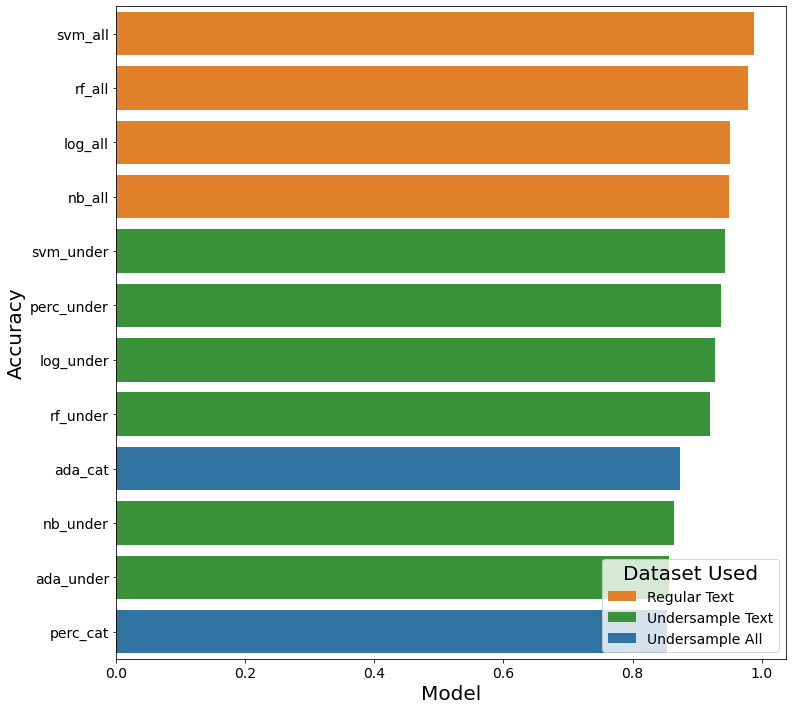

In [75]:
Results_acc = Results_2.sort_values(by=['Accuracy'], ascending=False)
plt.clf()
plt.figure(figsize=[12,12])
plotac = sns.barplot(y = 'Model', x = 'Accuracy', hue = 'Dataset Used', data = Results_acc, dodge=False,
            palette = {'Regular Text' : 'tab:orange', 'Undersample Text': 'tab:green', 'Undersample All': 'tab:blue',})
plt.xlabel('Model',fontsize = 20)
plt.ylabel('Accuracy',fontsize =20)
plt.xticks(fontsize =14)
plt.yticks(fontsize = 14)
legend = plt.legend(loc = 'lower right', title = 'Dataset Used', fontsize = 14)
plt.setp(legend.get_title(), fontsize = 20)
plt.show()

F1 Score Plot

<Figure size 432x288 with 0 Axes>

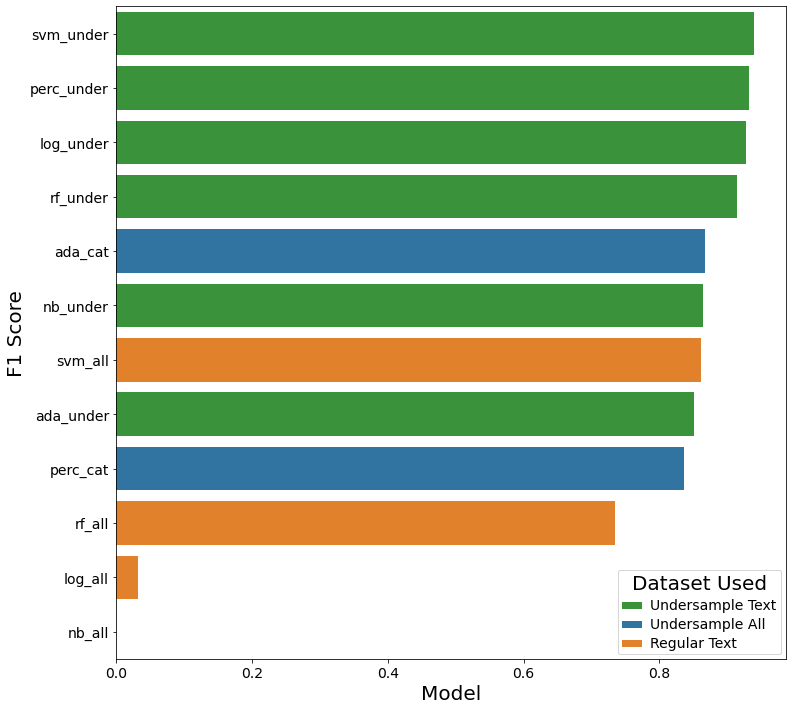

In [63]:
Results_f1 = Results_2.sort_values(by=['F1 Score'], ascending=False)
plt.clf()
plt.figure(figsize=[12,12])
plotf1 = sns.barplot(y = 'Model', x = 'F1 Score', hue = 'Dataset Used', data = Results_f1, dodge=False,
            palette = {'Regular Text' : 'tab:orange', 'Undersample Text': 'tab:green', 'Undersample All': 'tab:blue',})
plt.xlabel('Model',fontsize = 20)
plt.ylabel('F1 Score',fontsize =20)
plt.xticks(fontsize =14)
plt.yticks(fontsize = 14)
plt.setp(plotf1.get_legend().get_texts(), fontsize = 14)
plt.setp(plotf1.get_legend().get_title(), fontsize = 20)
plt.show()